In [6]:
#Determine whether skewness and curtosis are important to map daily 
#historical/warmer temp distributions to pre-industrial conditions.

In [7]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

In [8]:
# def write_dslist_zarr(ds_list, paths):
#     for path, ds in zip([paths, ds_list])
#         ds.to_zarr(path)
#     return
  
# def write_dslist_netcdf(ds_list, paths):
#     for path, ds in zip([paths, ds_list])
#         ds.to_netcdf(path)
#     return 

# def get_datasets(ds_names,paths,engine,recalc):
#     for path,ds in zip([paths, ds_names])
#         ds = xr.open_mfdataset(paths,engine=engine)
#     return ds_names
       

In [9]:
#LAT        = 56.07 #LON        = 347.5
#LAT        = 44.06 #LON        = 245.257
#Boston
#LAT        = 
#LON        = 360-87.6298
#Bengaluru:
LAT        = 12.9716
LON        = 77.5946
savefigs   = '/global/scratch/users/harsha/savefigs/Nov15/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/'
loc        = 'columbia'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'

In [10]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=20, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(10)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42996 instead
  warnings.warn(


In [11]:
pi_year0 = '1870'
pi_year1 = '1900'
ic_year0 = '2070'
ic_year1 = '2100'
doy      = 1 # day_of_year
date     = 'Jan1'

In [12]:
cluster

In [13]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 570 ms, sys: 91.6 ms, total: 661 ms
Wall time: 694 ms


In [14]:
%%time
#Close to (LAT, LON) ;t-temp, nw - no-warming, w-warming

tw  = ds_ssp.TREFHTMX.sel(lat=LAT,lon=LON,method='nearest',\
         time=ds_ssp.time.dt.dayofyear==doy).sel(time=slice(ic_year0,ic_year1))

tnw = ds_hist.TREFHTMX.sel(lat=LAT,lon=LON,method='nearest',\
         time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(pi_year0,pi_year1))

CPU times: user 233 ms, sys: 23 ms, total: 256 ms
Wall time: 252 ms


In [15]:
%%time
#d = day/daily
tdnw = tnw.stack(mtime=('member','time'),create_index=False)
tdw  = tw.stack(mtime=('member','time'),create_index=False)
#twj30.mean().values - tnwj30.mean().values 
#tdw.std().values 

CPU times: user 5.45 ms, sys: 51 µs, total: 5.5 ms
Wall time: 5.32 ms


In [16]:
tnw

<xarray.DataArray 'TREFHTMX' (time: 31, member: 100)>
dask.array<getitem, shape=(31, 100), dtype=float32, chunksize=(10, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 12.72
    lon      float64 77.5
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time     (time) object 1870-01-01 00:00:00 ... 1900-01-01 00:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [17]:
# Set paths for local tmax - warming, no warming and corrected.
dnw_path = cvals+'tnw'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dw_path  = cvals+'tw'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dc_path  = cvals+'tc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmc_path = cvals+'tmc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
print(dnw_path) 
print(dw_path)
print(dmc_path)

/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/tnwJan1_2070_2100_loc.zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/twJan1_2070_2100_loc.zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/tmcJan1_2070_2100_loc.zarr


In [18]:
%%time
# Save daily,local tmax, mc = mean corrected
tdc  = (tdw - tdw.mean())*(tdnw.std()/tdw.std()) + tdnw.mean()
tdmc = (tdw - tdw.mean())+tdnw.mean()
tdc.mean().values - tdnw.mean().values
# tdnw.to_dataset().to_zarr(dnw_path)
# tdw.to_dataset().to_zarr(dw_path)
# tdc.to_dataset().to_zarr(dc_path)
# tdmc.to_dataset().to_zarr(dmc_path)

CPU times: user 24 s, sys: 1.57 s, total: 25.6 s
Wall time: 2min 47s


3.0517578e-05

In [19]:
%%time
# tdnw = xr.open_mfdataset(dnw_path,engine='zarr')
# tdw  = xr.open_mfdataset(dw_path,engine='zarr')
# tdc  = xr.open_mfdataset(dc_path,engine='zarr')
# tdw  = tdw.TREFHTMX
# tdnw = tdnw.TREFHTMX
# tdc  = tdc.TREFHTMX

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


In [20]:
%%time
tdmwa = tdw.mean('mtime')-tdnw.mean('mtime')
print(tdmwa.values)
print(tdw.std('mtime').values - tdnw.std('mtime').values)

3.66156
0.19093966
CPU times: user 20.2 s, sys: 826 ms, total: 21.1 s
Wall time: 1min 34s


In [21]:
tdwa   = tdw  - tdnw
tdca   = tdc  - tdnw
tdmca  = tdmc - tdnw
tdwa

<xarray.DataArray 'TREFHTMX' (mtime: 3100)>
dask.array<sub, shape=(3100,), dtype=float32, chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 12.72
    lon      float64 77.5
    member   (mtime) int64 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99 99
Dimensions without coordinates: mtime

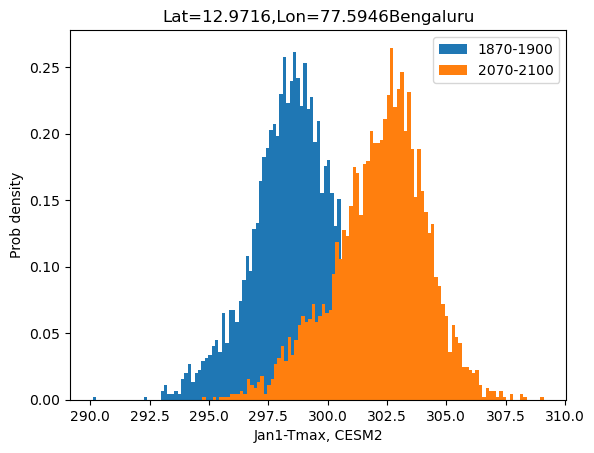

CPU times: user 9.93 s, sys: 389 ms, total: 10.3 s
Wall time: 46.2 s


In [22]:
%%time
plt.hist(tdnw,density='True',bins=100,label=pi_year0+'-'+pi_year1)
plt.hist(tdw, density='True',bins=100, label=ic_year0+'-'+ic_year1)
#plt.hist(tdc, density='True',bins=100, label='Adj')
plt.xlabel(date+'-Tmax, CESM2')
plt.ylabel('Prob density')
plt.title('Lat='+str(LAT)+',Lon='+str(LON)+'Bengaluru')
plt.legend(loc='upper right')
plt.show()

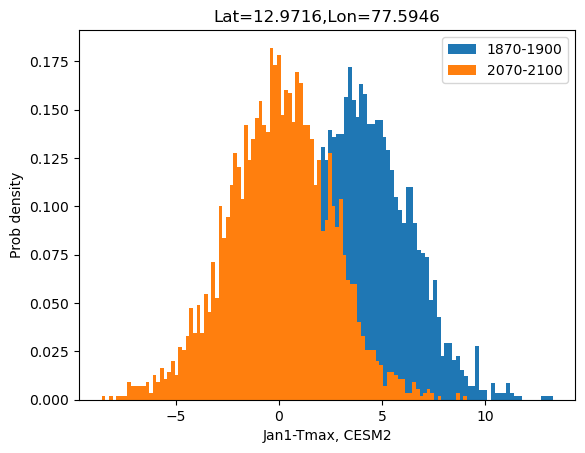

CPU times: user 26.7 s, sys: 995 ms, total: 27.7 s
Wall time: 1min 26s


In [23]:
%%time
plt.hist(tdwa,density='True',bins=100,label=pi_year0+'-'+pi_year1)
plt.hist(tdca, density='True',bins=100, label=ic_year0+'-'+ic_year1)
#plt.hist(tdc, density='True',bins=100, label='Adj')
plt.xlabel(date+'-Tmax, CESM2')
plt.ylabel('Prob density')
plt.title('Lat='+str(LAT)+',Lon='+str(LON))
plt.legend(loc='upper right')
#plt.savefig(savefigs+loc+'_pdf_'+date+'.png')
plt.show()

In [24]:
%%time
counts_wa, bins_wa     = np.histogram(tdwa,bins=30,density='True',range=(-12,15))
bins_wa                = bins_wa[:-1] + (bins_wa[1] - bins_wa[0])/2
#  prob_nw            = counts_nw/float(counts_nw.sum())
counts_wca, bins_wca   = np.histogram(tdca,bins=30,density='True',range=(-12,15))
bins_wca               = bins_wca[:-1] + (bins_wca[1] - bins_wca[0])/2
# ##############
counts_wmca, bins_wmca = np.histogram(tdmca,bins=30,density='True',range=(-12,15))
bins_wmca              = bins_wmca[:-1] + (bins_wmca[1] - bins_wmca[0])/2

CPU times: user 39.3 s, sys: 1.31 s, total: 40.6 s
Wall time: 2min 15s


CPU times: user 32.3 ms, sys: 3.99 ms, total: 36.3 ms
Wall time: 32.7 ms


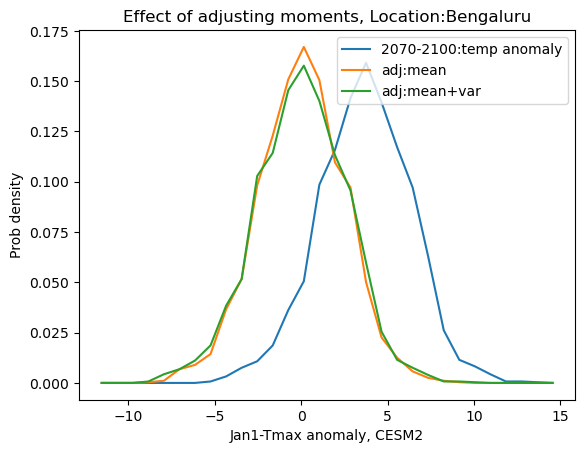

In [25]:
%%time
plt.plot(bins_wa,counts_wa,label='2070-2100:temp anomaly')
plt.plot(bins_wca,counts_wca,label='adj:mean')
plt.plot(bins_wmca,counts_wmca,label='adj:mean+var')
plt.xlabel(date+'-Tmax anomaly, CESM2')
plt.ylabel('Prob density')
plt.title('Effect of adjusting moments, Location:Bengaluru')
plt.legend(loc='upper right')

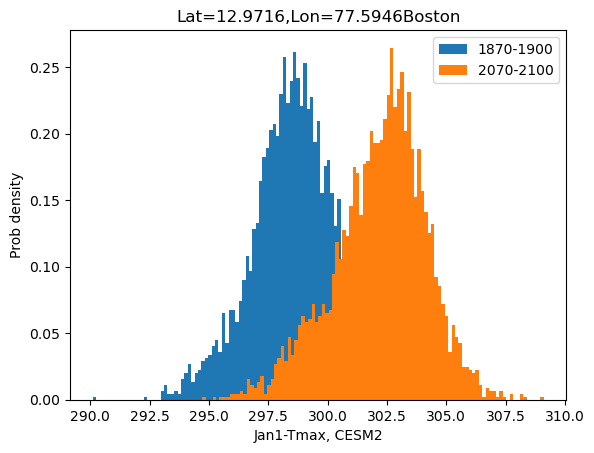

CPU times: user 10.2 s, sys: 395 ms, total: 10.6 s
Wall time: 50 s


In [26]:
%%time
plt.hist(tdnw,density='True',bins=100,label=pi_year0+'-'+pi_year1)
plt.hist(tdw, density='True',bins=100, label=ic_year0+'-'+ic_year1)
#plt.hist(tdc, density='True',bins=100, label='Adj')
plt.xlabel(date+'-Tmax, CESM2')
plt.ylabel('Prob density')
plt.title('Lat='+str(LAT)+',Lon='+str(LON)+'Boston')
plt.legend(loc='upper right')
plt.show()

In [27]:
%%time
#Compute quantile function - Jan 30 tmax
quants = np.arange(0,1,0.001)
qdnw   = tdnw.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdw    = tdw.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdc    = tdc.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmc   = tdmc.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')

CPU times: user 27 ms, sys: 4.03 ms, total: 31.1 ms
Wall time: 28.8 ms


In [28]:
qdnw

<xarray.DataArray 'TREFHTMX' (quantile: 1000)>
dask.array<transpose, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999

In [29]:
qdwa  = qdw-qdnw
qdca  = qdc-qdnw #w= warming, a = anomaly
qdmca = qdc-qdnw
qdw   = qdw.rename({'quantile':'permilles'})
qdc   = qdc.rename({'quantile':'permilles'})
qdmc  = qdmc.rename({'quantile':'permilles'})
qdnw  = qdnw.rename({'quantile':'permilles'})

In [30]:
qdw_path   = cvals+'qw'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdnw_path  = cvals+'qnw'+date+'_'+pi_year0+'_'+pi_year1+'.zarr'
qdc_path   = cvals+'qc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdmc_path  = cvals+'qmc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'

In [31]:
%%time
qdw.to_dataset().to_zarr(qdw_path,mode='w')
qdnw.to_dataset().to_zarr(qdnw_path,mode='w')
qdc.to_dataset().to_zarr(qdc_path,mode='w')
qdmc.to_dataset().to_zarr(qdmc_path,mode='w')

CPU times: user 32.6 s, sys: 1.21 s, total: 33.8 s
Wall time: 2min 24s


In [32]:
%%time
# qdnw  = xr.open_mfdataset(qdnw_path,engine='zarr')
# qdw   = xr.open_mfdataset(qdw_path,engine='zarr')
# qdc   = xr.open_mfdataset(qdc_path,engine='zarr')
# qdmc  = xr.open_mfdataset(qdmc_path,engine='zarr')
# qdnw  = qdnw.TREFHTMX
# qdw   = qdw.TREFHTMX
# qdc   = qdc.TREFHTMX
# qdmc  = qdmc.TREFHTMX
qdwa  = qdw-qdnw 
qdca  = qdc-qdnw #w= warming, a = anomaly
qdmca = qdmc-qdnw

CPU times: user 4.33 ms, sys: 5.02 ms, total: 9.34 ms
Wall time: 8.05 ms


In [33]:
qdmca

<xarray.DataArray 'TREFHTMX' (permilles: 1000)>
dask.array<sub, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>
Coordinates:
  * permilles  (permilles) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999

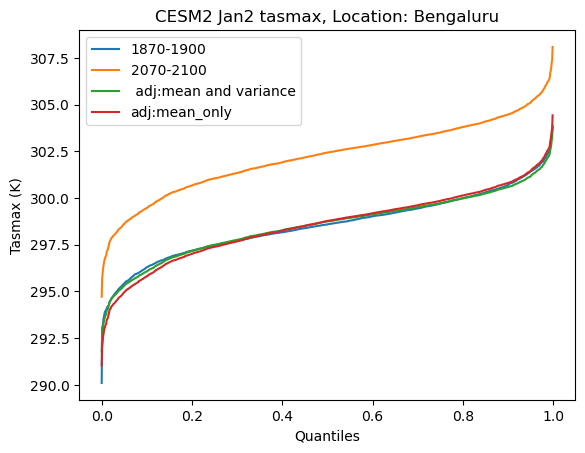

CPU times: user 31.9 s, sys: 1.15 s, total: 33 s
Wall time: 2min 20s


In [34]:
%%time
plt.plot(quants,qdnw,label=pi_year0+'-'+pi_year1)
plt.plot(quants,qdw,label=ic_year0+'-'+ic_year1)
plt.plot(quants,qdc,label=' adj:mean and variance')
plt.plot(quants,qdmc,label='adj:mean_only')
plt.xlabel('Quantiles')
plt.ylabel('Tasmax (K)')
plt.title('CESM2 Jan2 tasmax, Location: Bengaluru')
plt.legend(loc='upper left')
plt.show()

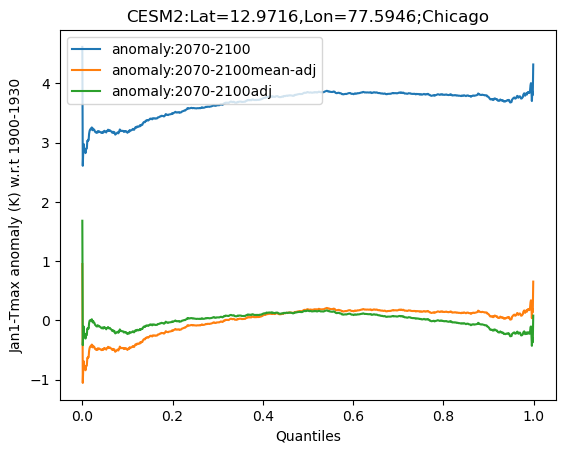

CPU times: user 32.6 s, sys: 1.11 s, total: 33.7 s
Wall time: 2min 15s


In [35]:
%%time
plt.plot(quants,qdwa,label='anomaly:'+ic_year0+'-'+ic_year1)
plt.plot(quants,qdmca,label='anomaly:'+ic_year0+'-'+ic_year1+'mean-adj')
plt.plot(quants,qdca,label='anomaly:'+ic_year0+'-'+ic_year1+'adj')
plt.legend(loc='upper left')
plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON)+';Chicago')
plt.ylabel(date+'-Tmax anomaly (K) w.r.t 1900-1930')
plt.xlabel('Quantiles')
plt.show()

In [36]:
tdnw = tdnw.chunk(mtime=-1)
tdw

<xarray.DataArray 'TREFHTMX' (mtime: 3100)>
dask.array<reshape, shape=(3100,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 12.72
    lon      float64 77.5
    member   (mtime) int64 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99 99
    time     (mtime) object 2070-01-01 00:00:00 ... 2100-01-01 00:00:00
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [37]:
%%time
######## Boostrap Confidence Intervals for the quantiles #####
#a = anopmaly, b=bootstrap samples
nboot   = 1000
tdnwb   = xs.resample_iterations(tdnw,nboot,'mtime')
tdwb    = xs.resample_iterations(tdw,nboot,'mtime')
tdcb    = xs.resample_iterations(tdc,nboot,'mtime')
tdmcb   = xs.resample_iterations(tdmc,nboot,'mtime')
qdnwb   = tdnwb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdwb    = tdwb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdcb    = tdcb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmcb   = tdmcb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdwab   = qdwb - qdnwb
qdcab   = qdcb - qdnwb
qdmcab  = qdmcb - qdnwb

CPU times: user 6min 8s, sys: 38.5 s, total: 6min 46s
Wall time: 6min 42s


In [38]:
qdmcab 

<xarray.DataArray 'TREFHTMX' (quantile: 1000, iteration: 1000)>
dask.array<sub, shape=(1000, 1000), dtype=float64, chunksize=(1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * iteration  (iteration) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * quantile   (quantile) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999

In [39]:
qdwab_path  = cvals+'qwab'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdcab_path  = cvals+'qcab'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdmcab_path = cvals+'qcab'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'

In [ ]:
tdwb.compute()

In [ ]:
%%time
qdwab     = qdwab.rename({'quantile':'permilles'})
qdcab     = qdcab.rename({'quantile':'permilles'})
qdmcab    = qdmcab.rename({'quantile':'permilles'})
CIs       = [0.025,0.975]
qdwa_ci   = qdwab.chunk(dict(iteration=-1)).quantile(CIs,dim='iteration')
qdca_ci   = qdcab.chunk(dict(iteration=-1)).quantile(CIs,dim='iteration')
qdmca_ci  = qdmcab.chunk(dict(iteration=-1)).quantile(CIs,dim='iteration')
qdmca_ci

In [ ]:
qdwa_ci

In [ ]:
qdwa_cipath  = cvals+'qdwa_ci' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdca_cipath  = cvals+'qdca_ci' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdmca_cipath = cvals+'qdmca_ci'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'

In [ ]:
%%time
#qdwca_ci.compute()
qdwa_ci

In [ ]:
%%time
#qdwa_ci   = qdwa_ci.rename('qdwa_ci')
#qdwca_ci  = qdca_ci.rename('qdca_ci')
#qdmca_ci  = qdmca_ci.rename('qdmca_ci')
qdwa_ci.to_dataset().to_zarr(qdwa_cipath,mode='w')
#qdca_ci.to_dataset().to_zarr(qdca_cipath,mode='w')
#qdmca_ci.to_dataset().to_zarr(qdmca_cipath,mode='w')

In [ ]:
%%time
qdwa_ci   = xr.open_mfdataset(qdwa_cipath,engine='zarr')
# qdca_ci   = xr.open_mfdataset(qdca_cipath,engine='zarr')
# qdmca_ci  = xr.open_mfdataset(qdmca_cipath,engine='zarr')
# qdwa_ci   = qdwa_ci.TREFHTMX.drop('quantile')
# qdca_ci   = qdca_ci.TREFHTMX.drop('quantile')
# qdmca_ci  = qdmca_ci.TREFHTMX.drop('quantile')

In [ ]:
quants = np.arange(0,1,0.001)
yzeros  = np.zeros(1000)

In [ ]:
#qdwa_ci = qdwa_ci.TREFHTMX
qdwa_ci

In [ ]:
%%time
#%matplotlib inline
#plt.plot(quants,qdwa,label='anomaly:2070to2100')
plt.plot(quants,yzeros,label='anomaly=0')
plt.fill_between(quants,qdwa_ci.sel(quantile=0.025),qdwa_ci.sel(quantile=0.975),color='r',alpha=0.1)
plt.legend(loc='upper left')
plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON))
plt.ylabel(date+'tmax anomaly (K) w.r.t 1900-1914')
plt.xlabel('Quantiles')
plt.show()

In [ ]:
%%time
#%matplotlib inline
plt.plot(quants,qdca,label='anomaly:2070to2100adj')
plt.plot(quants,yzeros,label='anomaly=0')
plt.fill_between(quants,qdca_cilb,qdca_ciub,color='b',alpha=0.1)
plt.plot(quants,qdwa,label='anomaly:2070to2100')
plt.fill_between(quants,qdwa_cilb,qdwa_ciub,color='r',alpha=0.1)
plt.legend(loc='upper left')
plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON))
plt.ylabel(date+'tmax anomaly (K) w.r.t 1900-1914')
plt.xlabel('Quantiles')
plt.show()

In [ ]:
qdwa_cilb

In [ ]:
qdwa.values

In [ ]:
%%time
qdca_count0 = (qdca_cilb <=0).sum(axis=0)/1000
qdca_count0.values

In [ ]:
qdca_cilb.values

In [ ]:
%%time
qdca_count1 = (qdwa_ciub >0).sum(axis=0)/1000
qdca_count1.values

In [ ]:
################## RMSE -Old ###############

In [ ]:
rmse_qwaj30 = np.sqrt(np.mean(np.square(qwaj30))) #Assuming anomaly =0 is 'true'.
rmse_qcaj30 = np.sqrt(np.mean(np.square(qcaj30)) )
rmse_qwaj30,rmse_qcaj30

In [ ]:
1- (rmse_qcaj30*rmse_qcaj30)/(rmse_qwaj30*rmse_qwaj30)

In [ ]:
mse_qwaj30 = np.mean(np.square(qwaj30))
mse_qcaj30 = np.mean(np.square(qcaj30))
mse_qwaj30, mse_qcaj30

In [ ]:
#mse_qj30gca
mse_qj30gca.sel(lat=LAT,lon=LON,method='nearest').compute()

In [ ]:
mse_qj30gwa.sel(lat=LAT,lon=LON,method='nearest').compute()

In [ ]:
%%time
#Use histogram to compute cdfs- Jan 30
hist_wj30, bins_wj30   = np.histogram(twj30,bins=50,density='True')
hist_nwj30, bins_nwj30 = np.histogram(tnwj30,bins=50,density='True')
hist_cj30, bins_cj30   = np.histogram(twj30_corr,bins=50,density='True')
cdf_wj30               = np.diff(bins_wj30)*np.cumsum(hist_wj30)
cdf_nwj30              = np.diff(bins_nwj30)*np.cumsum(hist_nwj30)
cdf_cj30               = np.diff(bins_cj30)*np.cumsum(hist_cj30)

In [ ]:
%%time
plt.plot(bins_wj30[1:],cdf_wj30,label='1950-2014')
plt.plot(bins_nwj30[1:],cdf_nwj30,label='1850-1914')
plt.plot(bins_cj30[1:],cdf_cj30,label='1950-2014:Adj')
plt.xlabel('Tmax, Jan 30, CESM2')
plt.legend(loc='upper left')
plt.ylabel('CDF')
plt.title('Lat='+str(LAT)+',Lon='+str(LON))
plt.savefig(savefigs+loc+'_cdf_jan30.png')
plt.show()


In [ ]:
########### RMSE Globe #################
quants = np.arange(0,1,0.01)
tnwg = ds_temp.TREFHTMX.sel(time=slice('18500101','19141231')) 
twg  = ds_temp.TREFHTMX.sel(time=slice('19500101','20141231'))

In [ ]:
#tnwg

In [ ]:
tj30wg   = twg.isel(time=jan30[:65])
#tj30wg

In [ ]:
%%time
#January 30th
jan30    = np.arange(170)
jan30    = jan30*365 +29
tj30nwg  = tnwg.isel(time=jan30[:65])
tj30wg   = twg.isel(time=jan30[:65])
tj30gnw  = tj30nwg.stack(mtime=('member','time'))
tj30gw   = tj30wg.stack(mtime=('member','time'))

In [ ]:
#tj30gw

In [ ]:
tj30gwc = (tj30gw - tj30gw.mean('mtime'))*(tj30gnw.std('mtime')/tj30gw.std('mtime')) + tj30gnw.mean('mtime')
#twj30_corr = (twj30 - twj30.mean())*(tnwj30.std()/twj30.std()) + tnwj30.mean()

In [ ]:
#xr.align(tj30gw,tj30nw,join='exact')

In [ ]:
corr_ano = tj30gwc.mean('mtime') - tj30gnw.mean('mtime')

In [ ]:
#corr_ano.plot()

In [ ]:
corr_sano = tj30gwc.std('mtime') - tj30gnw.std('mtime')

In [ ]:
#corr_sano.plot()

In [ ]:
%time
qj30gnw = tj30gnw.chunk(dict(mtime=-1,lat=1)).quantile(quants,dim='mtime')
qj30gw  = tj30gw.chunk(dict(mtime=-1,lat=1)).quantile(quants,dim='mtime') #g=global
qj30gwc = tj30gwc.chunk(dict(mtime=-1,lat=1)).quantile(quants,dim='mtime') #c=corrected

In [ ]:
%time
qj30gwa    =  qj30gw-qj30gnw
qj30gca    =  qj30gwc-qj30gnw

In [ ]:
#Create Zero dataarray for true value
lats      = qj30gnw['lat'].data
lons      = qj30gnw['lon'].data
temp      = np.zeros((100,lats.size,lons.size,))
quantiles = qj30gnw['quantile'].data
#########################
tv = xr.DataArray(
    data=temp,
    dims=['quantile','lat', "lon"],
    coords=dict(
        lon      =(["lon"], lons),
        lat      =(["lat"], lats),
        quantile =(['quantile'],quantiles),
    ),
    attrs=dict(
        description="2m air temperature.",
        units="degK",
    ),
)
####################
tv = tv.chunk(dict(quantile=100,lat=1,lon=288))

In [ ]:
tv

In [ ]:
rmse_qj30gwa = xs.rmse(qj30gwa,tv,dim='quantile')
rmse_qj30gca = xs.rmse(qj30gca,tv,dim='quantile')

In [ ]:
%time 
rmse_path = '/global/scratch/users/harsha/CESM2/LENS/cvals/rmse' 
rmse_qj30gwa = rmse_qj30gwa.to_dataset()
rmse_qj30gca = rmse_qj30gca.to_dataset()
rmse_qj30gwa.to_zarr(rmse_path+'jan30_rmse_ano1950_2014.zarr')
rmse_rmse_qj30gca.to_zarr(rmse_path+'jan30_rmse_ano1950_2014_adj.zarr')

In [ ]:
%time
thresh =0.4
#vmin = np.min(obs_ano)
#vmax = np.max(obs_ano)
vmin = -5.0
vmax = 5.0
wcolors,wbins = get_colors_list(vmin,vmax,-thresh,thresh,0.2)
wbins = np.arange(vmin,vmax+0.2,0.5)
wcmap = colors.LinearSegmentedColormap.from_list('terrain_map_white', wcolors)


In [ ]:
%time
#levels = np.arange(0,4,0.4)
ax = plt.axes(projection=cart.crs.PlateCarree())
levs = np.arange(0,5,0.5)
#colors= ['v','i','b','g','y','o','c','m','w']
rmse_qj30gwa.plot.contourf(ax=ax,levels =levs,cmap='rainbow',transform=cart.crs.PlateCarree())
ax.coastlines(color="red")
plt.title('RMSEs of tmax anomaly 1950-2014')
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()


In [ ]:
mse_qj30gwa = xs.mse(qj30gwa,tv,dim='quantile')
mse_qj30gca = xs.mse(qj30gca,tv,dim='quantile')
#xr.align(mse_qj30gwa,mse_qj30gwa,join='outer')

In [ ]:
gsignal = 1 - (mse_qj30gca/mse_qj30gwa)
gsignal

In [ ]:
%time
msig = gsignal.where(gsignal==gsignal.min(),drop='True').squeeze()

In [ ]:
#gsignal.rename(signal)
%time
lsig = gsignal.where(gsignal<0.1,drop='True').squeeze()

In [ ]:
gsignal.sel(lat=LAT,lon=LON,method='nearest').compute()